In [1]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
  confusion_matrix,
  roc_curve,
  roc_auc_score,
  precision_score,
  recall_score,
  f1_score,
  accuracy_score,
)
from xgboost import XGBClassifier

In [2]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
data_path = path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)
df.head()

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
list(df.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [4]:
useless_cols = [
  "customerID",
  "MultipleLines",
]

rename_map = {
  "tenure": "subscription_tenure_months",
  "Contract": "billing_cycle_type",
  "MonthlyCharges": "MonthlyCharges",
  "TotalCharges": "TotalCharges",
  "InternetService": "PlanType",
  "PhoneService": "ProductEnabled",
  "OnlineBackup": "OnlineBackup",
  "StreamingTV": "FeatureA",
  "StreamingMovies": "FeatureB",
  "PaymentMethod": "PaymentMethod",
  "SeniorCitizen": "is_senior_user",
  "Partner": "has_partner",
  "Dependents": "has_dependents",
}
existing = [c for c in useless_cols if c in df.columns]
df = df.drop(columns=existing)
rename_map_existing = {k: v for k, v in rename_map.items() if k in df.columns}
df = df.rename(columns=rename_map_existing)
list(df.columns)

['gender',
 'is_senior_user',
 'has_partner',
 'has_dependents',
 'subscription_tenure_months',
 'ProductEnabled',
 'PlanType',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'FeatureA',
 'FeatureB',
 'billing_cycle_type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [5]:
label_enc = LabelEncoder()
df["Churn"] = label_enc.fit_transform(df["Churn"])

if "TotalCharges" in df.columns:
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
  df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
  X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
num_cols = X_train_full.select_dtypes(include="number").columns
cat_cols = X_train_full.select_dtypes(exclude="number").columns

numeric_preprocessor = Pipeline(
  steps=[
  ("scaler", StandardScaler()),
  ]
)
categorical_preprocessor = Pipeline(
  steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
   ]
)

preprocessor = ColumnTransformer(
  [
    ("categorical", categorical_preprocessor, cat_cols),
    ("numerical", numeric_preprocessor, num_cols),
  ]
)

In [7]:
pos = y_train_full.sum()
neg = (y_train_full == 0).sum()
spw = neg / pos

In [8]:
# These hyperparameters are selected based on Baysian Optimization Technique with Weights & Biases Toolkit
best_model = XGBClassifier(
  random_state=42,
  n_estimators=300,
  learning_rate=0.2075852071646683,
  max_depth=2,
  gamma=3.885341033809145,
  scale_pos_weight=spw,
  eval_metric="logloss",
  n_jobs=-1,
)

pipe = Pipeline(
  steps=[
    ("prep", preprocessor),
    ("model", best_model),
    ]
)

In [9]:
pipe.fit(X_train_full, y_train_full);

In [10]:
y_test_proba = pipe.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)


recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)
cm = confusion_matrix(y_test, y_test_pred)

print("=== Test Metrics (best sweep model) ===")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion matrix:\n", cm)

=== Test Metrics (best sweep model) ===
Recall:    0.7968
Precision: 0.5059
F1-score:  0.6189
Accuracy:  0.7395
ROC AUC:   0.8433
Confusion matrix:
 [[744 291]
 [ 76 298]]


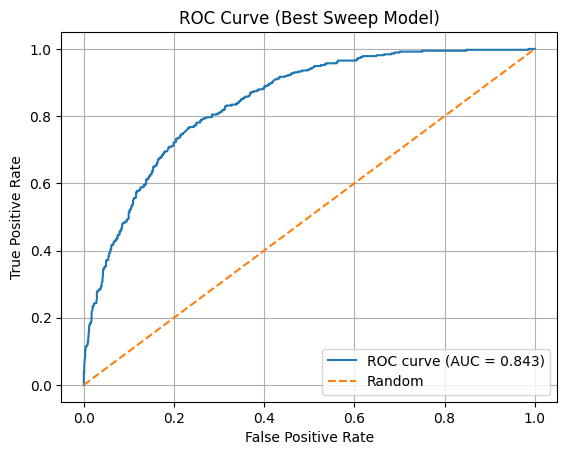

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Sweep Model)")
plt.legend()
plt.grid(True)
plt.show()

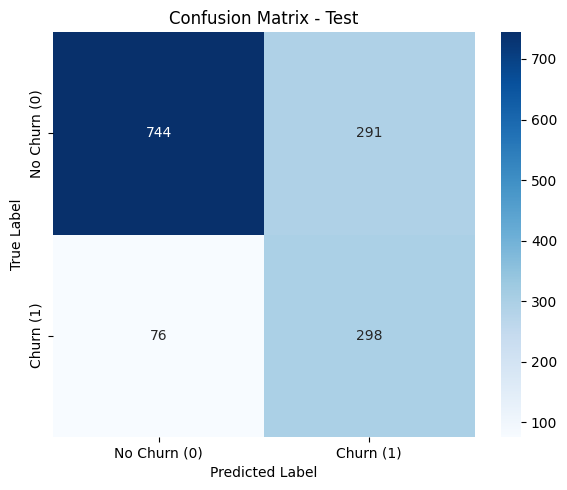

In [12]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(
  cm,
  annot=True,
  fmt="d",
  cmap="Blues",
  xticklabels=["No Churn (0)", "Churn (1)"],
  yticklabels=["No Churn (0)", "Churn (1)"],
)

plt.title("Confusion Matrix - Test")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()